### ISI和cv计算并行版

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numba import njit, prange
# 自定义函数
from import_fun import HH_model, Iz_model, Euler, RK4, spikes_eval_Iz
from import_fun import record_spike_times, calculate_isi, calculate_cv

In [2]:
@njit
def ISI_CV(N, method, dt, Iex):
    t = 0

    # nodes = HH_model

    # 创建节点
    nodes = Iz_model
    params_nodes = {
            "a": 0.02,
            "b": 0.2,
            "c": -65.,
            "d": 8.,
            "threshold":30.,
            "Iex": 10.
        }
    
    mem0 = np.random.uniform(-.1, .1, N)
    u0 = np.random.rand(N)
    vars_nodes = np.vstack((mem0, u0))

    N_vars = 2  # 变量的数量

    params_nodes["Iex"] = Iex

    # 模型放电变量
    flag = np.zeros(N, dtype=np.int32)           # 模型放电标志(>0, 放电)
    flaglaunch = np.zeros(N, dtype=np.int32)     # 模型开始放电标志(==1, 放电刚刚开始)
    firingTime = np.zeros(N)                     # 记录放电时间(上次放电)
    # 初始化峰值时间记录相关变量
    max_spikes = 1000                                 # 假设每个神经元最多记录 1000 次放电
    spike_times = np.full((N, max_spikes), np.nan)
    spike_counts = np.zeros(N, dtype=np.int32)   # 放电次数计数

    for _ in range(100_00):
        I = np.zeros((N_vars, N))
        params_list = list(params_nodes.values())
        method(nodes, vars_nodes, t, dt, I, params_list)  #

        thresh, c, d = params_nodes["threshold"], params_nodes["c"], params_nodes["d"]
        spikes_eval_Iz(vars_nodes, t, thresh, flaglaunch, firingTime, c, d)

        t += dt  # 时间前进

    # mem = []
    # time = []
    # 计算ISI和CV
    for _ in range(1000_00):
        I = np.zeros((N_vars, N))
        params_list = list(params_nodes.values())
        method(nodes, vars_nodes, t, dt, I, params_list)  #

        thresh, c, d = params_nodes["threshold"], params_nodes["c"], params_nodes["d"]
        spikes_eval_Iz(vars_nodes, t, thresh, flaglaunch, firingTime, c, d)
        record_spike_times(flaglaunch, t, spike_times, spike_counts, max_spikes)


        t += dt  # 时间前进
        # mem.append(vars_nodes[0].copy())
        # time.append(t)

    isi_array = calculate_isi(spike_times, spike_counts, N)[0]

    cv_array = calculate_cv(spike_times, spike_counts, N)[0]

    return isi_array, cv_array
    # return mem, time

In [3]:
dt = 0.01
method = Euler   # （Euler, RK4）
N = 1
# Iex = 0
Iex_list1 = np.linspace(0, 100, 1000)

In [4]:
# isi_array, cv_array = ISI_CV(N, method, dt, Iex)

In [ ]:
@njit(parallel=True)
def parallel_isi_cv(Iex_list, N, method, dt):
    n = len(Iex_list)
    N = 100
    isi_list = np.full((n, N), np.nan)
    cv_list = np.full(n, np.nan)
    
    for i in prange(n):
        Iex = Iex_list[i]
        isi_array, cv_array = ISI_CV(N, method, dt, Iex)
        len_isi = len(isi_array)
        if len_isi > N: len_isi = N
        isi_list[i, :len_isi] = isi_array[:len_isi]
        cv_list[i] = cv_array
        
    return isi_list, cv_list

In [6]:
isi_list, cv_list = parallel_isi_cv(Iex_list1, N, method, dt)

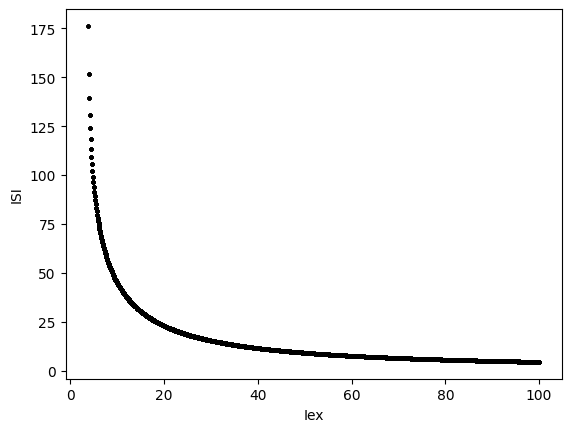

In [7]:
plt.plot(Iex_list1, isi_list, 'o',  markersize=2, color="k")
plt.xlabel("Iex")
plt.ylabel("ISI")
plt.show()

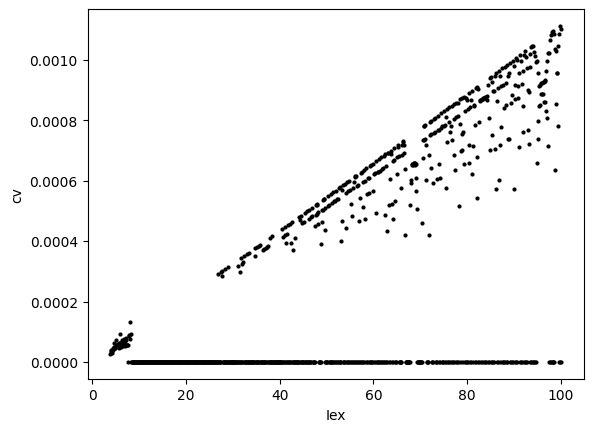

In [8]:
plt.plot(Iex_list1, cv_list, 'o',  markersize=2, color="k")
plt.xlabel("Iex")
plt.ylabel("cv")
plt.show()

In [9]:
# mem, time = ISI_CV(N, method, dt, Iex)
# plt.plot(time, mem)